# Preprocessing Data : 

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
from collections import Counter
import pycountry_convert as pc

In [47]:
df = pd.read_csv("imdb.csv")

def convert_duration(duration):
    parts = duration.split()
    total_minutes = 0
    for part in parts:
        if 'h' in part:
            total_minutes += int(part.rstrip('h')) * 60
        elif 'm' in part:
            total_minutes += int(part.rstrip('m'))
    return total_minutes

df['Duration'] = df['Duration'].apply(convert_duration)

print(df['Duration'])


0       142
1       152
2       148
3       139
4       142
       ... 
4718     95
4719    115
4720    119
4721    139
4722    112
Name: Duration, Length: 4723, dtype: int64


In [48]:
df['Meta Score'] = df['Meta Score'].astype(int)

In [49]:
def convert_votes(votes_str):
    if 'K' in votes_str:
        return int(float(votes_str.rstrip('K')) * 1000)
    elif 'M' in votes_str:
        return int(float(votes_str.rstrip('M')) * 1000000)
    else:
        return int(votes_str)

df['Number of Votes'] = df['Number of Votes'].apply(convert_votes)

## Budget Preprocessing

In the dataset most of the budgets movie has been written in USD. We want to convert all of the budjets to USD to have a unique numerical variable.   

### Gross world wide feature

For clean this feature we should:

 - Remove $ sign.
 - Clean the budget value:
    Every 3 digits of budget has been seperated with ','. for example $200,500,000. It must convert to $20050000 

In [50]:
def convert_currency(value):
    if isinstance(value, str) and value.startswith('$'):
        return int(value.replace('$', '').replace(',', ''))
    else:
        return value

df['Gross (worldwide)'] = df['Gross (worldwide)'].apply(convert_currency)

### Budjet Feature

The budget feature has the problem to So we must clean the budget value.

In [51]:
def clean_budget_value(value):
        return str(value.replace(',', ''))
    
df['Budget'] = df['Budget'].apply(clean_budget_value)

All of the budgets are not in USD. The 'Budget' column contains various currency symbols. In this block of code we print them.

In [52]:
def extract_prefix(budget):
    match = re.match(r'([^\d]+)', str(budget).strip())
    if match:
        return match.group(1)
    return None


df['Prefix'] = df['Budget'].apply(extract_prefix)
unique_prefixes = df['Prefix'].dropna().unique()

unique_prefixes_list = unique_prefixes.tolist()
print(unique_prefixes_list)

['$', 'FRF\xa0', '€', '£', 'R$', '₹', '¥', 'DKK\xa0', 'DEM\xa0', '₩', 'CA$', 'RUR\xa0', 'ITL\xa0', 'CN¥', 'NOK\xa0', 'ATS\xa0', 'A$', 'SEK\xa0', 'BEF\xa0', 'THB\xa0', 'NZ$', 'SGD\xa0', 'HUF\xa0']


These prefixes appear to be international currency symbols and codes. The presence of non-breaking space characters (\xa0) indicates that some of the prefixes include a space character that might need to be cleaned up.

To convert the currency budget to USD, we'll need to use exchange rates for each currency.

Here’s a step-by-step approach:

1. **Define exchange rates** for each currency symbol.
2. **Extract the numeric part** and **currency prefix**.
3. **Convert the values** to USD using the exchange rates.
4. **Create a new column** with the converted value

In [53]:
exchange_rates = {
    '$': 1.0,       # USD to USD 
    'FRF': 0.17,    # French Franc to USD
    '€': 1.1,       # Euro to USD
    '£': 1.3,       # British Pound to USD
    'R$': 0.2,      # Brazilian Real to USD
    '₹': 0.012,     # Indian Rupee to USD
    '¥': 0.0073,    # Japanese Yen to USD
    'DKK': 0.15,    # Danish Krone to USD
    'DEM': 0.51,    # German Mark to USD
    '₩': 0.00079,   # South Korean Won to USD
    'CA$': 0.78,    # Canadian Dollar to USD
    'RUR': 0.014,   # Russian Ruble to USD
    'ITL': 0.00058, # Italian Lira to USD
    'CN¥': 0.16,    # Chinese Yuan to USD
    'NOK': 0.1,     # Norwegian Krone to USD
    'ATS': 0.08,    # Austrian Schilling to USD
    'A$': 0.76,     # Australian Dollar to USD
    'SEK': 0.12,    # Swedish Krona to USD
    'BEF': 0.027,   # Belgian Franc to USD
    'THB': 0.031,   # Thai Baht to USD
    'NZ$': 0.70,    # New Zealand Dollar to USD
    'SGD': 0.74,    # Singapore Dollar to USD
    'HUF': 0.0034   # Hungarian Forint to USD
}

def extract_currency_and_amount(budget):
    budget = str(budget).replace('\xa0', ' ').strip()
    match = re.match(r'([^\d\s]+)?\s?(\d+)', budget)
    if match:
        prefix = match.group(1)
        amount = match.group(2)
        return prefix, float(amount)
    return None, None

def convert_to_usd(prefix, amount):
    if prefix in exchange_rates:
        return amount * exchange_rates[prefix]
    return amount

df['Prefix'], df['Amount'] = zip(*df['Budget'].apply(extract_currency_and_amount))
df['Budget'] = df.apply(lambda row: convert_to_usd(row['Prefix'], row['Amount']), axis=1)
df = df.drop(columns=['Prefix', 'Amount'])

print(df['Budget'])

0        25000000.0
1       185000000.0
2       160000000.0
3        63000000.0
4        55000000.0
           ...     
4718     21150000.0
4719     13000000.0
4720      5850000.0
4721     30000000.0
4722     36000000.0
Name: Budget, Length: 4723, dtype: float64


In [54]:
df.describe()

,Release Year,Duration,Rating,Number of Votes,Meta Score,Budget,Gross (worldwide)
count,4723.000000,4723.000000,4723.000000,4.723000e+03,4723.000000,4.723000e+03,4.723000e+03
mean,2003.634131,111.319500,6.661211,1.730934e+05,57.971840,4.126330e+07,1.282343e+08
std,13.426662,20.303296,0.930746,2.319778e+05,17.924634,4.744922e+07,2.094351e+08
min,1950.000000,63.000000,1.500000,2.600000e+04,1.000000,1.560000e+03,1.260000e+02
25%,1997.000000,97.000000,6.100000,5.000000e+04,45.000000,1.000000e+07,1.900423e+07
50%,2006.000000,108.000000,6.700000,9.400000e+04,58.000000,2.500000e+07,5.540421e+07
75%,2013.000000,121.000000,7.300000,1.960000e+05,71.000000,5.400000e+07,1.479074e+08
max,2024.000000,321.000000,9.300000,2.900000e+06,100.000000,3.560000e+08,2.923706e+09


## Companies Feature

In [55]:
all_companies = df['Companies'].str.split('~').explode()
company_counts = Counter(all_companies)
top_companies = company_counts.most_common(25)
top_df = pd.DataFrame(top_companies, columns=['Company', 'Frequency'])
print(top_df)
print(top_df['Frequency'].sum() / df.shape[0])

                      Company  Frequency
0                Warner Bros.        372
1          Universal Pictures        362
2           Columbia Pictures        315
3          Paramount Pictures        309
4       Twentieth Century Fox        220
5        Walt Disney Pictures        176
6             New Line Cinema        171
7   Metro-Goldwyn-Mayer (MGM)        113
8            Relativity Media        110
9         Dreamworks Pictures        107
10    New Regency Productions        105
11        Touchstone Pictures        105
12            Lionsgate Films         87
13  Village Roadshow Pictures         84
14                    Miramax         72
15       Summit Entertainment         70
16       Amblin Entertainment         59
17                StudioCanal         56
18                Screen Gems         55
19          Fox 2000 Pictures         54
20             Focus Features         54
21    Legendary Entertainment         53
22           TriStar Pictures         53
23      Imagine 

### Countries Feature

For dealing with countries feature we one hot them by their continent.  

In [56]:
def country_to_continent(country_name):
    if country_name == 'United States':
        country_name = "United States of America"

    if country_name == 'West Germany':
        country_name = "Germany"

    if country_name == 'Netherlands Antilles':
        country_name = "Venezuela"
    
    if country_name == 'Soviet Union':
        country_name = "Russia"
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    
    except LookupError:
        print(f"Country: {country_name} Not found")
        return "Not found"

In [57]:
df['Country_list'] = df['Country of Origin'].str.split('~')
df['Continents'] = df['Country_list'].apply(lambda countries: [country_to_continent(country) for country in countries])


all_continents = set(continent for sublist in df['Continents'] for continent in sublist)
for continent in all_continents:
    df[continent] = df['Continents'].apply(lambda x: int(continent in x))


df.drop(df[df['Not found'] == 1].index, inplace=True)
df = df.drop(columns=['Country_list', 'Continents', 'Not found'])


df.describe()

Country: Serbia and Montenegro Not found
Country: Federal Republic of Yugoslavia Not found
Country: Yugoslavia Not found


,Release Year,Duration,Rating,Number of Votes,Meta Score,Budget,Gross (worldwide),Oceania,Asia,North America,Africa,South America,Europe
count,4720.000000,4720.000000,4720.000000,4.720000e+03,4720.000000,4.720000e+03,4.720000e+03,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000
mean,2003.642797,111.307415,6.660763,1.731650e+05,57.971822,4.127936e+07,1.282914e+08,0.047034,0.122669,0.913983,0.008686,0.005720,0.342797
std,13.421396,20.282864,0.930735,2.320341e+05,17.926348,4.745925e+07,2.094856e+08,0.211734,0.328092,0.280419,0.092805,0.075424,0.474694
min,1950.000000,63.000000,1.500000,2.600000e+04,1.000000,1.560000e+03,1.260000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1997.000000,97.000000,6.100000,5.000000e+04,45.000000,1.000000e+07,1.905996e+07,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,2006.000000,108.000000,6.700000,9.500000e+04,58.000000,2.500000e+07,5.541870e+07,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,2013.000000,121.000000,7.300000,1.960000e+05,71.000000,5.400000e+07,1.479695e+08,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,2024.000000,321.000000,9.300000,2.900000e+06,100.000000,3.560000e+08,2.923706e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Generes Feature



In [58]:
df['Genre_list'] = df['Genre'].str.split('~')

all_genres = set(genre for sublist in df['Genre_list'] for genre in sublist)
print("total number of generes: ", len(all_genres))

for genre in all_genres:
    df[genre] = df['Genre_list'].apply(lambda x: int(genre in x))

df = df.drop(columns=['Genre_list', 'Genre'])




total number of generes:  22


In [59]:
df.describe()

,Release Year,Duration,Rating,Number of Votes,Meta Score,Budget,Gross (worldwide),Oceania,Asia,North America,...,Fantasy,Comedy,Film-Noir,Romance,Thriller,Sport,Musical,Western,Drama,Mystery
count,4720.000000,4720.000000,4720.000000,4.720000e+03,4720.000000,4.720000e+03,4.720000e+03,4720.000000,4720.000000,4720.000000,...,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000,4720.000000
mean,2003.642797,111.307415,6.660763,1.731650e+05,57.971822,4.127936e+07,1.282914e+08,0.047034,0.122669,0.913983,...,0.091737,0.360805,0.001907,0.144703,0.176059,0.021610,0.009958,0.007203,0.493432,0.115678
std,13.421396,20.282864,0.930735,2.320341e+05,17.926348,4.745925e+07,2.094856e+08,0.211734,0.328092,0.280419,...,0.288685,0.480285,0.043630,0.351839,0.380911,0.145422,0.099300,0.084576,0.500010,0.319872
min,1950.000000,63.000000,1.500000,2.600000e+04,1.000000,1.560000e+03,1.260000e+02,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1997.000000,97.000000,6.100000,5.000000e+04,45.000000,1.000000e+07,1.905996e+07,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2006.000000,108.000000,6.700000,9.500000e+04,58.000000,2.500000e+07,5.541870e+07,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2013.000000,121.000000,7.300000,1.960000e+05,71.000000,5.400000e+07,1.479695e+08,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,2024.000000,321.000000,9.300000,2.900000e+06,100.000000,3.560000e+08,2.923706e+09,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
df.to_csv("preprocessed_imdb.csv", index=False)

# EDA : 

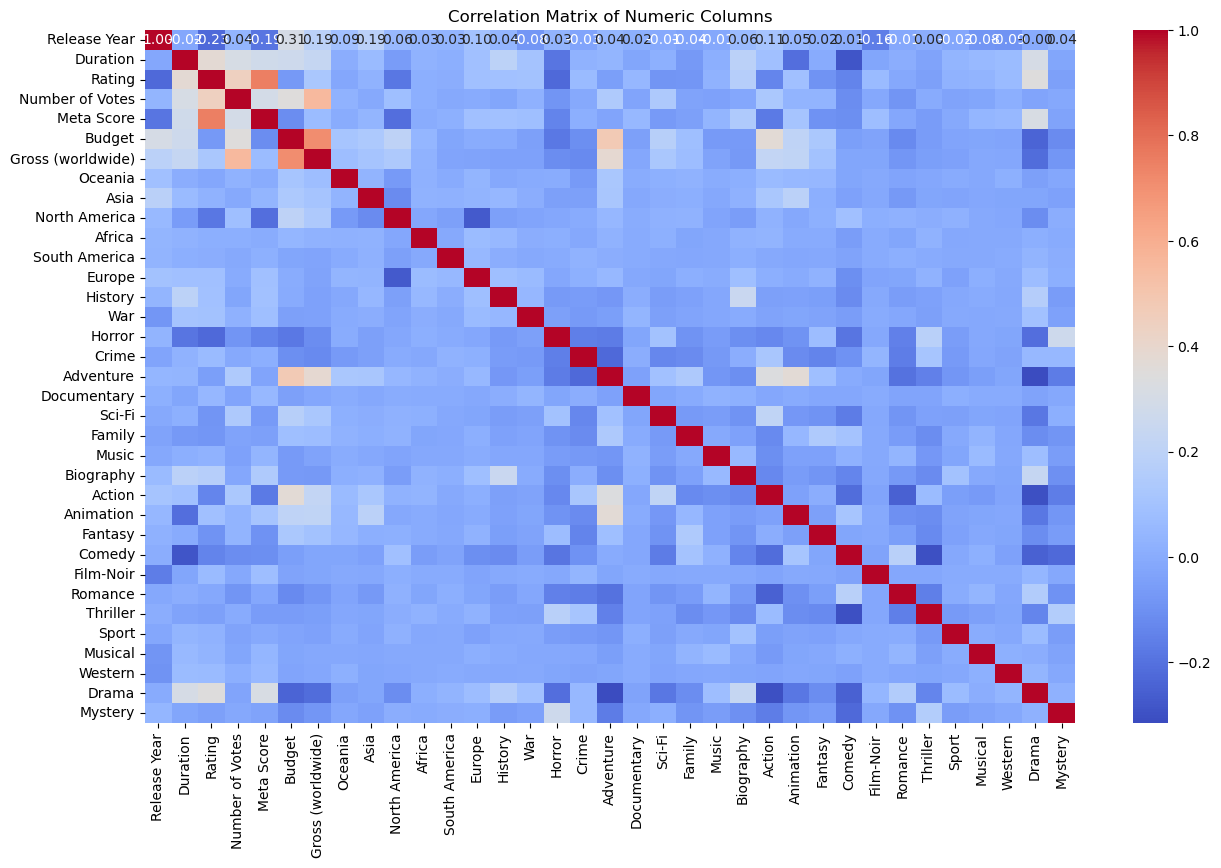

In [44]:
df = pd.read_csv("preprocessed_imdb.csv")

numeric_columns = df.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(15, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Columns')
plt.show()

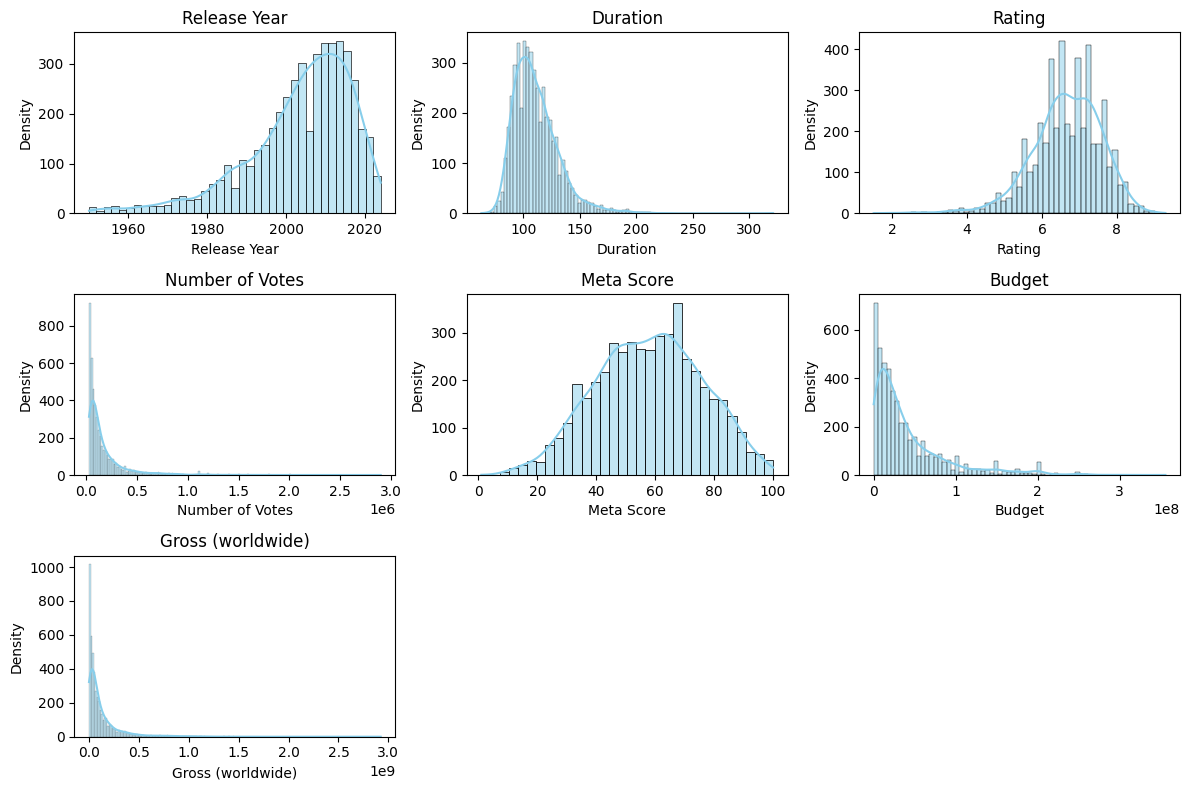

In [17]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_columns.columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(data=df, x=col, kde=True, color='skyblue', edgecolor='black')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

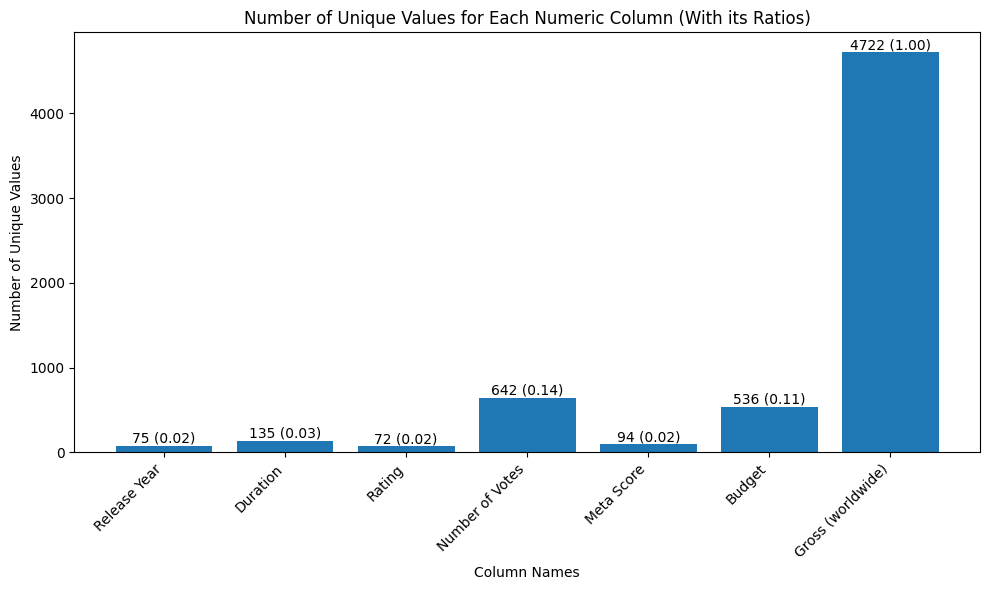

In [18]:
column_names = []
unique_value_counts = []
ratios = []

for column in numeric_columns.columns:
    column_names.append(column)
    unique_count = len(df[column].value_counts())
    unique_value_counts.append(unique_count)
    ratio = unique_count / len(df)
    ratios.append(ratio)

plt.figure(figsize=(10, 6))
bars = plt.bar(column_names, unique_value_counts)
plt.xlabel('Column Names')
plt.ylabel('Number of Unique Values')
plt.title('Number of Unique Values for Each Numeric Column (With its Ratios)')
plt.xticks(rotation=45, ha='right')

for bar, count, ratio in zip(bars, unique_value_counts, ratios):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count} ({ratio:.2f})', ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Normalizing the data:

In [19]:
from sklearn.preprocessing import MinMaxScaler

numeric_columns = df.select_dtypes(include=['int', 'float'])
print(numeric_columns.head().columns)
df[numeric_columns.columns] =  MinMaxScaler().fit_transform(numeric_columns)

numeric_columns = df[numeric_columns.columns]

Index(['Release Year', 'Duration', 'Rating', 'Number of Votes', 'Meta Score',
       'Budget', 'Gross (worldwide)'],
      dtype='object')


<Figure size 1000x1000 with 0 Axes>

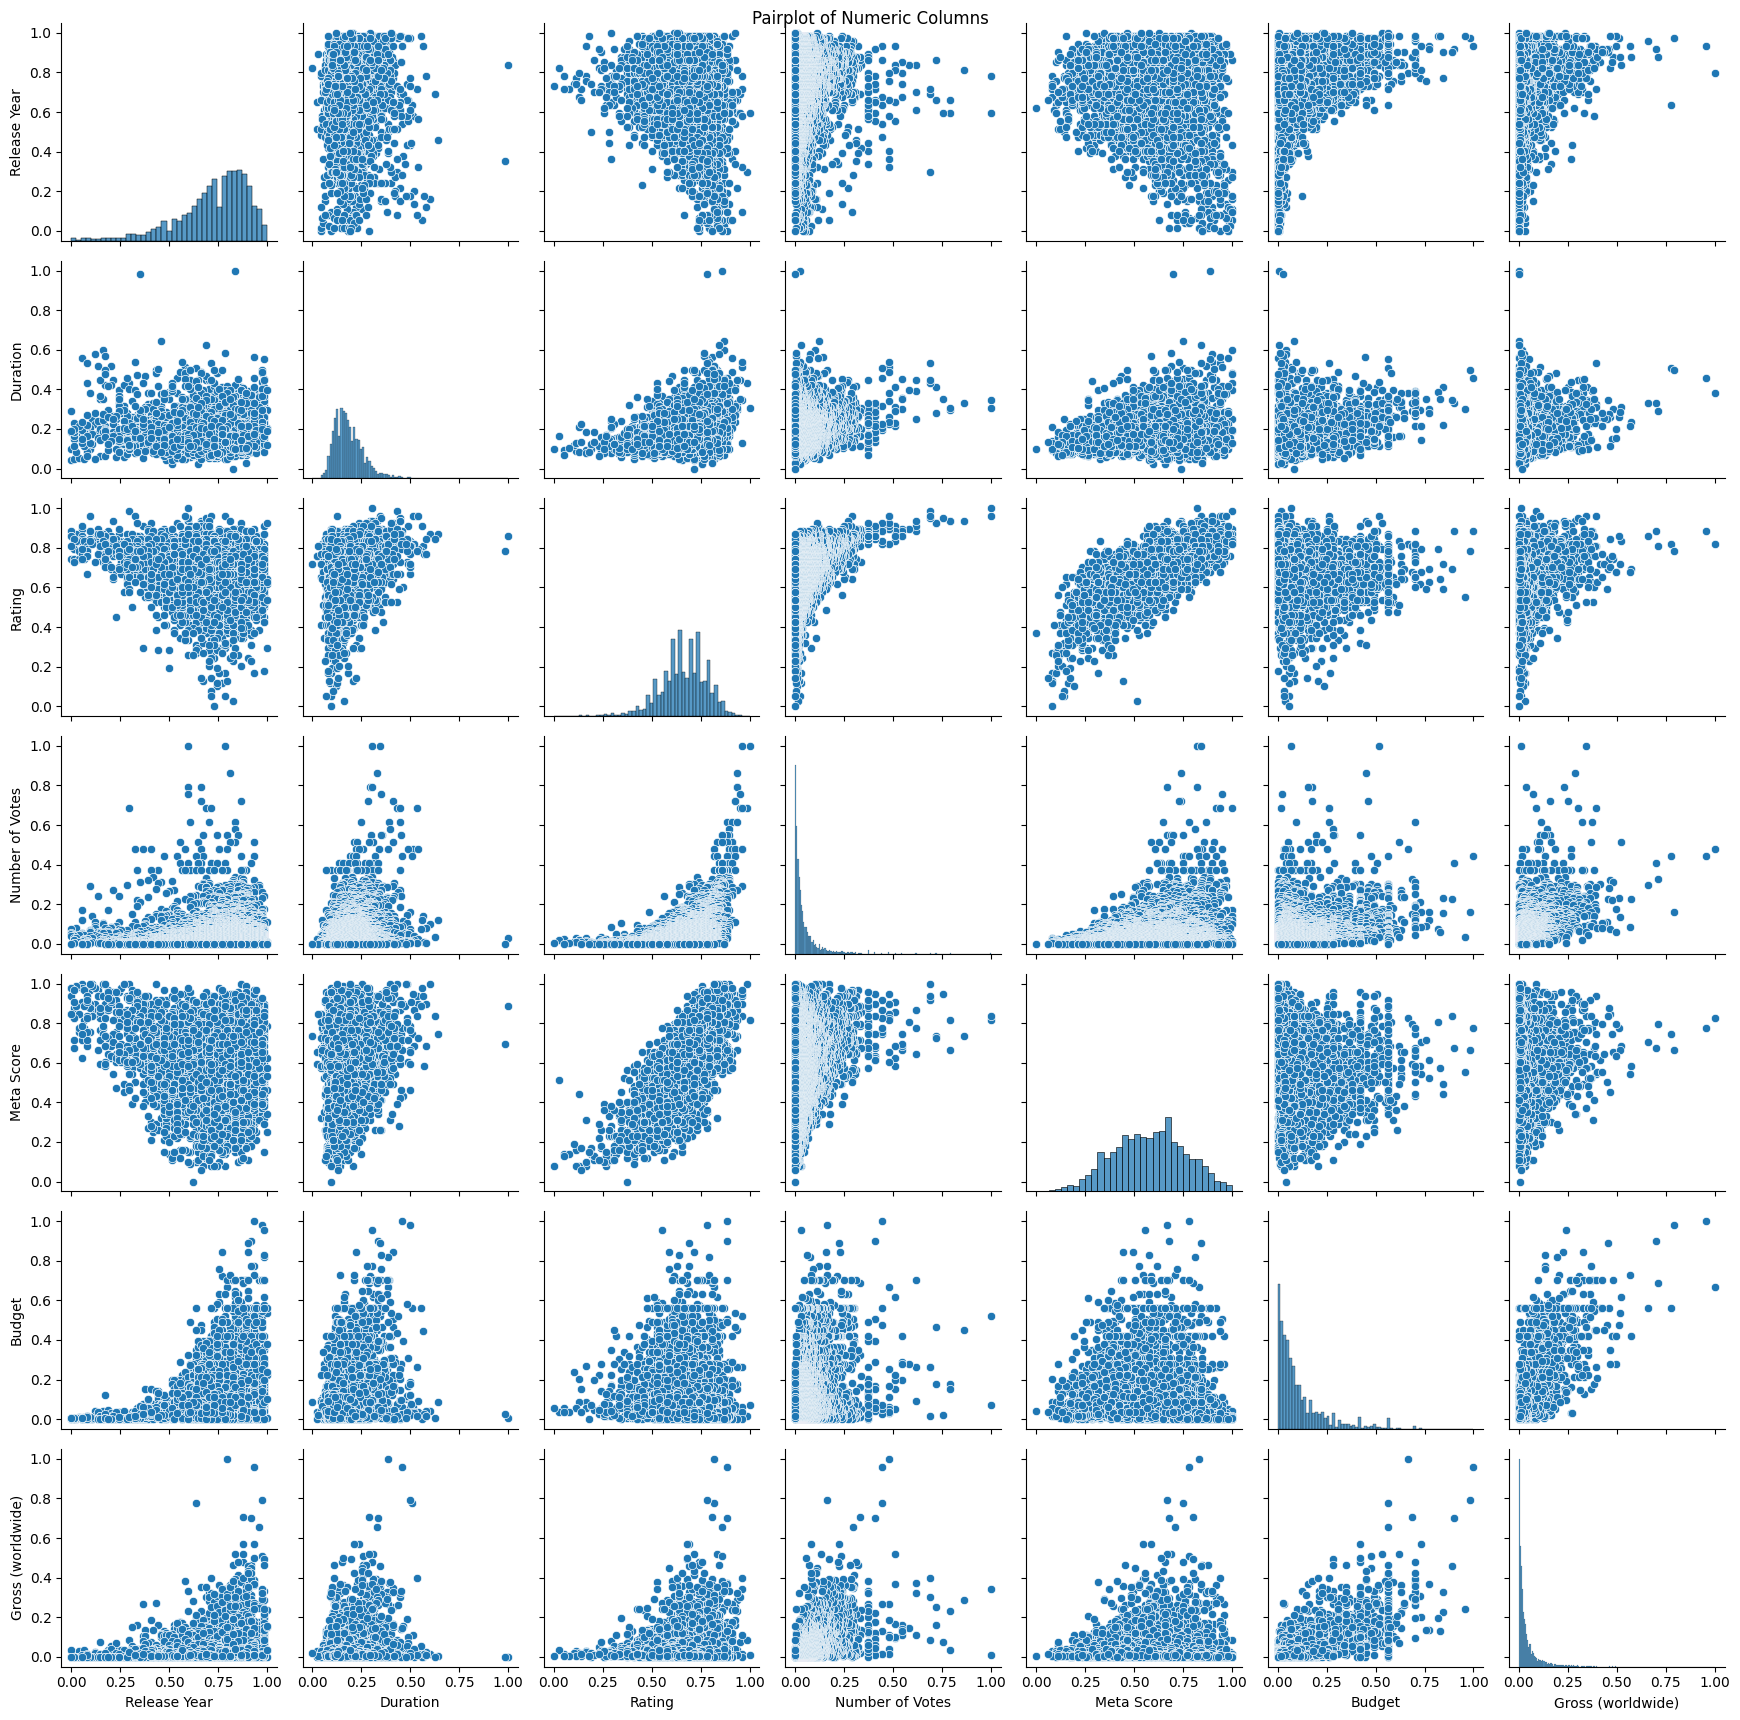

In [20]:
plt.figure(figsize=(10, 10))
sns.pairplot(data=numeric_columns)
plt.suptitle('Pairplot of Numeric Columns')
plt.tight_layout()
plt.show()



In the past, most people who voted for movies tended to give higher ratings. As the years have passed, we observe that ratings have become more spread out, with lower ratings also becoming more common.

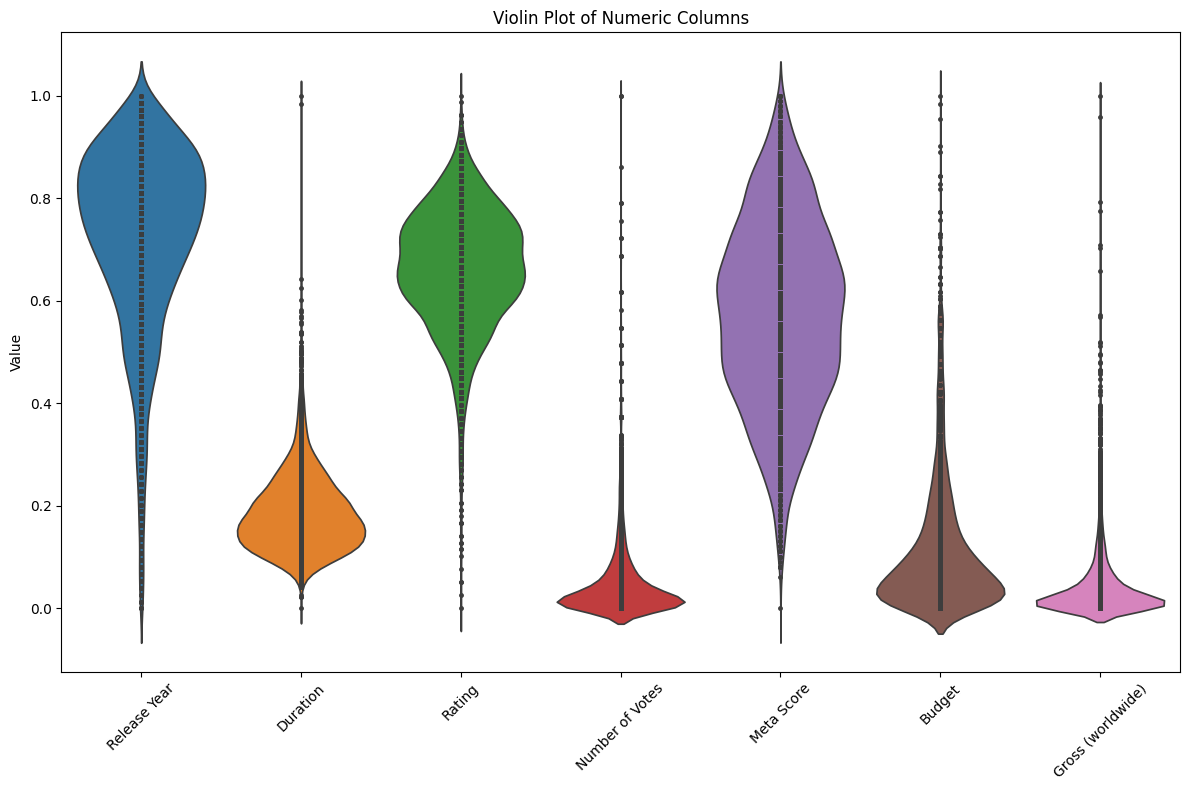

In [21]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=numeric_columns, orient='v', inner='point')
plt.title('Violin Plot of Numeric Columns')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
